This notebook will look further into Feature Importance. The previous notebook had anonymised the data where countries were considered as one rather than individually. While that works for general takeaways, this notebook will focus more on the impact of simply the country and no external factors and the effect that has on their tournament winnning odds.

#Load and Clean Data

In [ ]:
pip install shap

In [261]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import shap

In [262]:
data = pd.read_csv('euros_data.csv')
data.head(3)

,Team,FIFA Rank,Odds_to_One,Manager,Manager_Age,Contract until,Titles,Months_installed,Age,Height,Caps,Goals,MarketValue,Win Percentage,Q_GF,Q_GA,Q_GD,Q_PPG_Last_5,Q_Clean_Sheets,Q_xGF
0,Albania,66,500.0,Sylvinho,50,2024,0.0,17,27.308,183.615,26.115,1.538,4292308,38.709677,12.0,4.0,8.0,1.88,50%,1.13
1,Austria,25,66.0,Ralf Rangnick,65,2025,0.0,24,26.808,183.192,23.577,3.577,9057692,54.838710,17.0,7.0,10.0,2.38,38%,1.91
2,Belgium,3,16.0,Domenico Tedesco,38,2026,0.0,16,26.880,184.680,37.960,7.080,23380000,57.575758,22.0,4.0,18.0,2.50,63%,1.73


Change clean sheets to number to allow for regression analysis.

In [264]:
# Step 1: Rename the column
data.rename(columns={'Q_Clean_Sheets': 'Q_Clean_Sheets%'}, inplace=True)

# Step 2: Convert percentage values to numeric values
data['Q_Clean_Sheets%'] = data['Q_Clean_Sheets%'].str.rstrip('%').astype(float)

Drop Manager Data

In [265]:
data = data.drop(['Manager'], axis=1)

Drop Germany as NANs

In [266]:
data = data[data['Team'] != 'Germany']

In [267]:
data

,Team,FIFA Rank,Odds_to_One,Manager_Age,Contract until,Titles,Months_installed,Age,Height,Caps,Goals,MarketValue,Win Percentage,Q_GF,Q_GA,Q_GD,Q_PPG_Last_5,Q_Clean_Sheets%,Q_xGF
0,Albania,66,500.0,50,2024,0.0,17,27.308,183.615,26.115,1.538,4292308,38.709677,12.0,4.0,8.0,1.88,50.0,1.13
1,Austria,25,66.0,65,2025,0.0,24,26.808,183.192,23.577,3.577,9057692,54.838710,17.0,7.0,10.0,2.38,38.0,1.91
2,Belgium,3,16.0,38,2026,0.0,16,26.880,184.680,37.960,7.080,23380000,57.575758,22.0,4.0,18.0,2.50,63.0,1.73
3,Croatia,10,40.0,57,2026,0.0,80,27.692,184.115,44.308,5.654,12603846,59.459459,13.0,4.0,9.0,2.00,63.0,2.23
4,Czech Republic,36,150.0,60,2025,1.0,5,25.308,185.538,15.577,2.500,7457692,48.387097,12.0,6.0,6.0,1.88,50.0,1.83
5,Denmark,21,40.0,52,2026,1.0,46,27.692,186.269,41.192,5.192,15980769,65.625000,19.0,10.0,9.0,2.20,30.0,1.90
6,England,4,3.5,53,2024,0.0,92,26.077,182.462,25.038,3.846,58269231,55.882353,22.0,4.0,18.0,2.50,50.0,1.56
7,France,2,4.0,55,2026,2.0,143,26.880,184.440,33.440,7.680,49360000,63.888889,29.0,3.0,26.0,2.75,75.0,2.57
8,Georgia,75,500.0,47,2024,0.0,39,27.154,184.500,28.846,2.462,6159615,51.724138,14.0,18.0,-4.0,1.20,30.0,1.00
10,Hungary,26,80.0,59,2025,0.0,71,27.423,182.808,28.846,2.308,6325000,54.838710,16.0,7.0,9.0,2.25,38.0,1.67


In [268]:
data = data.reset_index(drop=True)

In [269]:
data

,Team,FIFA Rank,Odds_to_One,Manager_Age,Contract until,Titles,Months_installed,Age,Height,Caps,Goals,MarketValue,Win Percentage,Q_GF,Q_GA,Q_GD,Q_PPG_Last_5,Q_Clean_Sheets%,Q_xGF
0,Albania,66,500.0,50,2024,0.0,17,27.308,183.615,26.115,1.538,4292308,38.709677,12.0,4.0,8.0,1.88,50.0,1.13
1,Austria,25,66.0,65,2025,0.0,24,26.808,183.192,23.577,3.577,9057692,54.838710,17.0,7.0,10.0,2.38,38.0,1.91
2,Belgium,3,16.0,38,2026,0.0,16,26.880,184.680,37.960,7.080,23380000,57.575758,22.0,4.0,18.0,2.50,63.0,1.73
3,Croatia,10,40.0,57,2026,0.0,80,27.692,184.115,44.308,5.654,12603846,59.459459,13.0,4.0,9.0,2.00,63.0,2.23
4,Czech Republic,36,150.0,60,2025,1.0,5,25.308,185.538,15.577,2.500,7457692,48.387097,12.0,6.0,6.0,1.88,50.0,1.83
5,Denmark,21,40.0,52,2026,1.0,46,27.692,186.269,41.192,5.192,15980769,65.625000,19.0,10.0,9.0,2.20,30.0,1.90
6,England,4,3.5,53,2024,0.0,92,26.077,182.462,25.038,3.846,58269231,55.882353,22.0,4.0,18.0,2.50,50.0,1.56
7,France,2,4.0,55,2026,2.0,143,26.880,184.440,33.440,7.680,49360000,63.888889,29.0,3.0,26.0,2.75,75.0,2.57
8,Georgia,75,500.0,47,2024,0.0,39,27.154,184.500,28.846,2.462,6159615,51.724138,14.0,18.0,-4.0,1.20,30.0,1.00
9,Hungary,26,80.0,59,2025,0.0,71,27.423,182.808,28.846,2.308,6325000,54.838710,16.0,7.0,9.0,2.25,38.0,1.67


**Encode Country Column**

This step is the key difference compared to the previous notebook. It includes the country in the dataframe used in Modelling by using One Hot Encoding. This creates a new column for each country where 1 is registered if the row refers to that country. This is how the categorical data will be included in the regression analysis in this instance.

In [270]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_countries = pd.DataFrame(encoder.fit_transform(data[['Team']]), columns=encoder.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [271]:
# Merge the encoded countries back to the original data (excluding the original 'Country' column)
data_encoded = pd.concat([data.drop('Team', axis=1), encoded_countries], axis=1)

In [272]:
data_encoded

,FIFA Rank,Odds_to_One,Manager_Age,Contract until,Titles,Months_installed,Age,Height,Caps,Goals,...,Team_Portugal,Team_Romania,Team_Scotland,Team_Serbia,Team_Slovakia,Team_Slovenia,Team_Spain,Team_Switzerland,Team_Turkey,Team_Ukraine
0,66,500.0,50,2024,0.0,17,27.308,183.615,26.115,1.538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,66.0,65,2025,0.0,24,26.808,183.192,23.577,3.577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,16.0,38,2026,0.0,16,26.880,184.680,37.960,7.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,40.0,57,2026,0.0,80,27.692,184.115,44.308,5.654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36,150.0,60,2025,1.0,5,25.308,185.538,15.577,2.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,21,40.0,52,2026,1.0,46,27.692,186.269,41.192,5.192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4,3.5,53,2024,0.0,92,26.077,182.462,25.038,3.846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,4.0,55,2026,2.0,143,26.880,184.440,33.440,7.680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,75,500.0,47,2024,0.0,39,27.154,184.500,28.846,2.462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,26,80.0,59,2025,0.0,71,27.423,182.808,28.846,2.308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [273]:
data_encoded_cleaned = data_encoded.dropna()

In [274]:
data_encoded_cleaned

,FIFA Rank,Odds_to_One,Manager_Age,Contract until,Titles,Months_installed,Age,Height,Caps,Goals,...,Team_Portugal,Team_Romania,Team_Scotland,Team_Serbia,Team_Slovakia,Team_Slovenia,Team_Spain,Team_Switzerland,Team_Turkey,Team_Ukraine
0,66,500.0,50,2024,0.0,17,27.308,183.615,26.115,1.538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,66.0,65,2025,0.0,24,26.808,183.192,23.577,3.577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,16.0,38,2026,0.0,16,26.880,184.680,37.960,7.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,40.0,57,2026,0.0,80,27.692,184.115,44.308,5.654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36,150.0,60,2025,1.0,5,25.308,185.538,15.577,2.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,21,40.0,52,2026,1.0,46,27.692,186.269,41.192,5.192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4,3.5,53,2024,0.0,92,26.077,182.462,25.038,3.846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,4.0,55,2026,2.0,143,26.880,184.440,33.440,7.680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,75,500.0,47,2024,0.0,39,27.154,184.500,28.846,2.462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,26,80.0,59,2025,0.0,71,27.423,182.808,28.846,2.308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check data cleanliness

In [275]:
# Check for NaN values
print("Number of NaN values:", data_encoded.isna().sum().sum())

# Check for Inf values
print("Number of Inf values:", np.isinf(data_encoded).sum().sum())


Number of NaN values: 0
Number of Inf values: 0


In [276]:
# Display columns with NaN values and their counts
nan_counts = data_encoded.isna().sum()
print(nan_counts[nan_counts > 0])

Series([], dtype: int64)


In [277]:
data_encoded_cleaned = data_encoded.dropna()

In [278]:
# Display columns with NaN values and their counts
nan_counts = data_encoded_cleaned.isna().sum()
print(nan_counts[nan_counts > 0])

Series([], dtype: int64)


#Modelling

The features are scaled to allow for effective machine learning and to reduce the impact of outliers.

In [279]:
# Separate the features and the target variable
X = data_encoded_cleaned.drop('Odds_to_One', axis=1)
y = data_encoded_cleaned['Odds_to_One']

In [280]:
# Scale the numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [281]:
data_encoded_cleaned

,FIFA Rank,Odds_to_One,Manager_Age,Contract until,Titles,Months_installed,Age,Height,Caps,Goals,...,Team_Portugal,Team_Romania,Team_Scotland,Team_Serbia,Team_Slovakia,Team_Slovenia,Team_Spain,Team_Switzerland,Team_Turkey,Team_Ukraine
0,66,500.0,50,2024,0.0,17,27.308,183.615,26.115,1.538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,66.0,65,2025,0.0,24,26.808,183.192,23.577,3.577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,16.0,38,2026,0.0,16,26.880,184.680,37.960,7.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,40.0,57,2026,0.0,80,27.692,184.115,44.308,5.654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36,150.0,60,2025,1.0,5,25.308,185.538,15.577,2.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,21,40.0,52,2026,1.0,46,27.692,186.269,41.192,5.192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4,3.5,53,2024,0.0,92,26.077,182.462,25.038,3.846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,4.0,55,2026,2.0,143,26.880,184.440,33.440,7.680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,75,500.0,47,2024,0.0,39,27.154,184.500,28.846,2.462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,26,80.0,59,2025,0.0,71,27.423,182.808,28.846,2.308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Feature Importance is run with cross validation to increase test data size and model reliabilitiy.

In [282]:
import statsmodels.api as sm
# Add a constant to the predictor variables matrix (for the intercept)
X_scaled= sm.add_constant(X_scaled)

In [283]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_scaled,
                                                  y,
                                                  test_size=0.10,
                                                  shuffle=True,
                                                  random_state=324
                                                 )

In [284]:
import numpy as np
X = np.vstack((X_train, X_val))
y = np.concatenate((y_train, y_val))

Training countries: ['Albania' 'Austria' 'Belgium' 'Croatia' 'Denmark' 'England' 'France'
 'Georgia' 'Italy' 'Netherlands' 'Poland' 'Portugal' 'Scotland' 'Serbia'
 'Slovakia' 'Slovenia' 'Switzerland' 'Turkey']
Validation countries: ['Czech Republic' 'Hungary' 'Romania' 'Spain' 'Ukraine']
         Current function value: 587.173961
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1331: RuntimeWarning: overflow encountered in exp
  return -np.exp(XB) +  endog*XB - gammaln(endog+1)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1508: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1509: RuntimeWarning: invalid value encountered in multiply
  return (self.endog - L)[:,None] * X
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discre

Training countries: ['Albania' 'Austria' 'Belgium' 'Croatia' 'Czech Republic' 'England'
 'France' 'Georgia' 'Hungary' 'Poland' 'Portugal' 'Romania' 'Serbia'
 'Slovakia' 'Slovenia' 'Spain' 'Turkey' 'Ukraine']
Validation countries: ['Denmark' 'Italy' 'Netherlands' 'Scotland' 'Switzerland']
         Current function value: 654.950324
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Training countries: ['Belgium' 'Croatia' 'Czech Republic' 'Denmark' 'France' 'Georgia'
 'Hungary' 'Italy' 'Netherlands' 'Poland' 'Portugal' 'Romania' 'Scotland'
 'Slovakia' 'Slovenia' 'Spain' 'Switzerland' 'Ukraine']
Validation countries: ['Albania' 'Austria' 'England' 'Serbia' 'Turkey']


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 2.921529
         Iterations: 53
         Function evaluations: 126
         Gradient evaluations: 115
Training countries: ['Albania' 'Austria' 'Croatia' 'Czech Republic' 'Denmark' 'England'
 'Georgia' 'Hungary' 'Italy' 'Netherlands' 'Portugal' 'Romania' 'Scotland'
 'Serbia' 'Slovenia' 'Spain' 'Switzerland' 'Turkey' 'Ukraine']
Validation countries: ['Belgium' 'France' 'Poland' 'Slovakia']
         Current function value: 502.094337
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1331: RuntimeWarning: overflow encountered in exp
  return -np.exp(XB) +  endog*XB - gammaln(endog+1)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1508: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1509: RuntimeWarning: invalid value encountered in multiply
  return (self.endog - L)[:,None] * X
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discre

Training countries: ['Albania' 'Austria' 'Belgium' 'Czech Republic' 'Denmark' 'England'
 'France' 'Hungary' 'Italy' 'Netherlands' 'Poland' 'Romania' 'Scotland'
 'Serbia' 'Slovakia' 'Spain' 'Switzerland' 'Turkey' 'Ukraine']
Validation countries: ['Croatia' 'Georgia' 'Portugal' 'Slovenia']
         Current function value: 473.191987
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


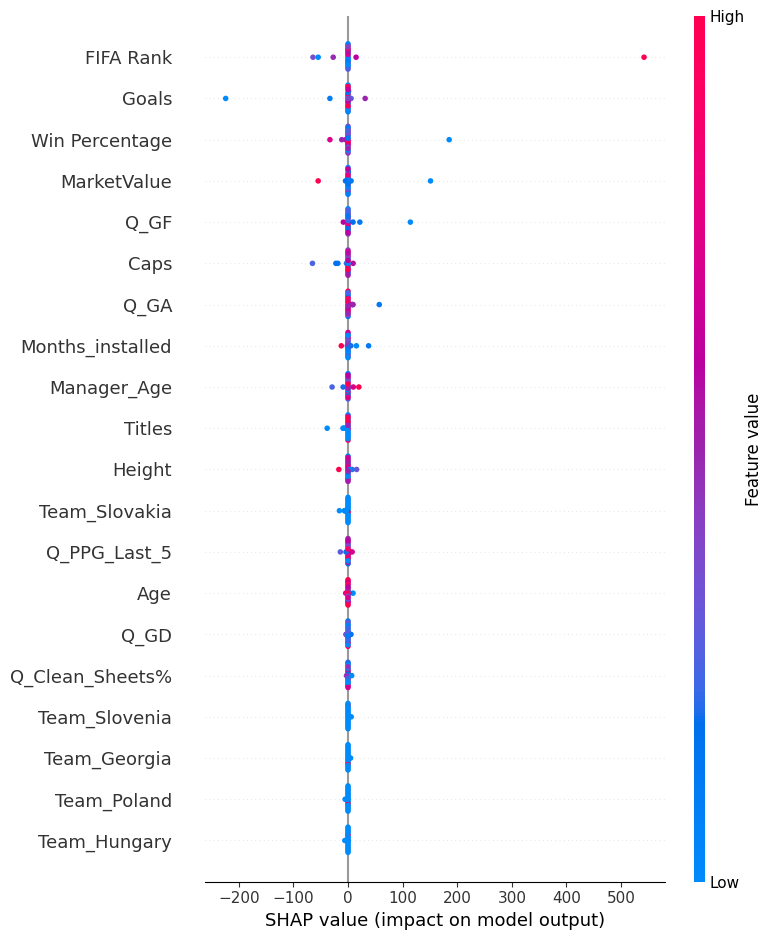

In [285]:
from sklearn.model_selection import GroupKFold
import numpy as np
import pandas as pd
import shap
import statsmodels.api as sm

# Example setup
X = data_encoded_cleaned.drop(columns=['Odds_to_One'])  # Your features

# Convert non-numeric columns to numeric (coerce errors to NaN)
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the median of each column
X = X.fillna(X.median())

# Ensure there are no remaining NaNs or Infs
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

y = data_encoded_cleaned['Odds_to_One']  # Your target variable

# Number of folds for cross-validation
n_splits = 5  # Adjust based on your needs
feature_names = X.columns.tolist()

# Initialize GroupKFold
group_kfold = GroupKFold(n_splits=n_splits)

# Store SHAP values and feature values
all_shap_values = []
all_feature_values = []

# Cross-validation loop
for train_index, val_index in group_kfold.split(X, y, groups):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    groups_train, groups_val = groups.iloc[train_index], groups.iloc[val_index]

    print(f"Training countries: {groups_train.unique()}")
    print(f"Validation countries: {groups_val.unique()}")

    try:
        # Initialize and fit the Zero-Inflated Poisson model
        zip_model = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit')
        zip_result = zip_model.fit(maxiter=100)  # Increase iterations if needed

        # Define a custom prediction function for SHAP
        def predict_function(X):
            return zip_result.predict(exog=X, exog_infl=X)

        # Create a SHAP explainer using the custom prediction function
        explainer = shap.Explainer(predict_function, X_train)

        # Calculate SHAP values for the validation fold
        shap_values = explainer(X_val)

        # Collect SHAP values and feature values for this fold
        all_shap_values.append(shap_values.values)
        all_feature_values.append(X_val)

    except Exception as e:
        print(f"Error in fold: {e}")

# Combine SHAP values from all folds
if all_shap_values:
    combined_shap_values = np.vstack(all_shap_values)
    combined_feature_values = np.vstack(all_feature_values)

    # Create a DataFrame for plotting
    shap_df = pd.DataFrame(combined_shap_values, columns=feature_names)
    feature_df = pd.DataFrame(combined_feature_values, columns=feature_names)

    # Create a SHAP Explanation object for combined SHAP values
    shap_values_combined = shap.Explanation(values=combined_shap_values, data=feature_df, feature_names=feature_names)

    # Plot combined SHAP values
    shap.summary_plot(shap_values_combined, feature_df, feature_names=feature_names)
else:
    print("No SHAP values collected.")


This SHAP output is reduced to contain only country columns as that is the focus of this particular analysis section.

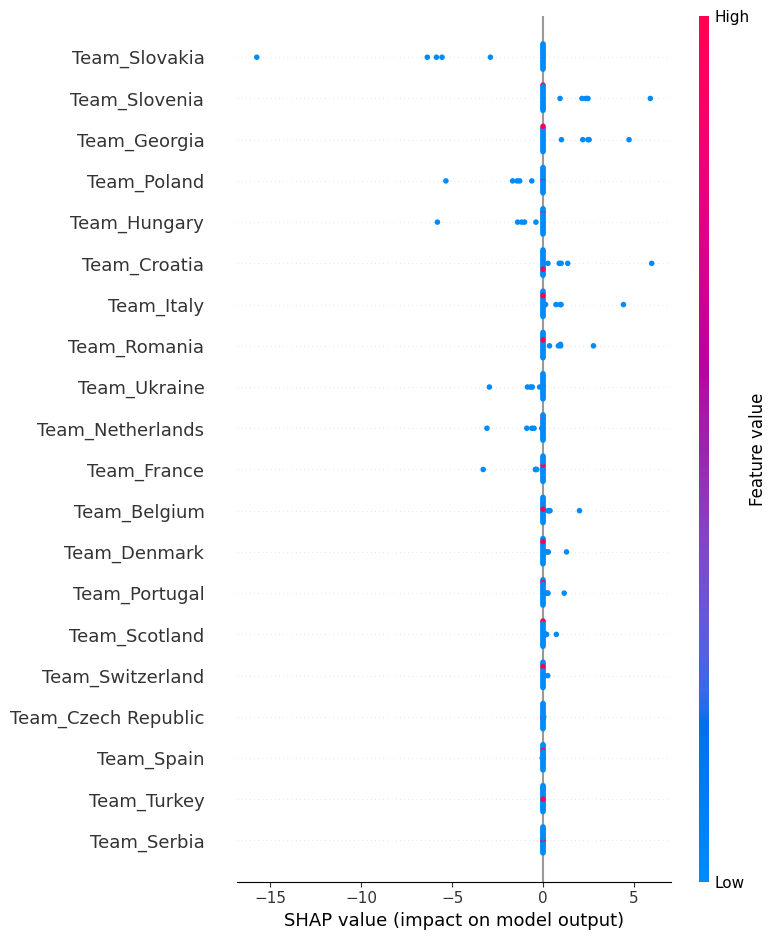

In [286]:
# Step 1: Identify country columns
country_columns = [col for col in feature_names if col.startswith('Team_')]

# Step 2: Filter SHAP values and feature values to include only country-related columns
shap_country_values = combined_shap_values[:, [feature_names.index(col) for col in country_columns]]
feature_country_values = combined_feature_values[:, [feature_names.index(col) for col in country_columns]]

# Step 3: Create a SHAP Explanation object for the country SHAP values
shap_values_country_combined = shap.Explanation(values=shap_country_values,
                                                data=feature_country_values,
                                                feature_names=country_columns)

# Step 4: Plot the SHAP values for countries
shap.summary_plot(shap_values_country_combined, feature_country_values, feature_names=country_columns)

Taking the mean aboslute SHAP value can show the features with the most impact on the model output.  

In [287]:
import numpy as np

# Calculate mean absolute SHAP values for each country
mean_abs_shap_values = np.abs(shap_country_values).mean(axis=0)

# Get feature names and their corresponding mean absolute SHAP values
country_shap_importance = list(zip(country_columns, mean_abs_shap_values))

# Sort countries based on their mean absolute SHAP values
sorted_country_shap_importance = sorted(country_shap_importance, key=lambda x: x[1], reverse=True)

# Print sorted countries with their importance
for country, importance in sorted_country_shap_importance:
    print(f'{country}: {importance}')


Team_Slovakia: 1.584168077612128
Team_Slovenia: 0.600818194278159
Team_Georgia: 0.562839251151343
Team_Poland: 0.4495713181272924
Team_Hungary: 0.4255788043135441
Team_Croatia: 0.4131941982392091
Team_Italy: 0.3138475177172772
Team_Romania: 0.2570599622812596
Team_Ukraine: 0.22910664192827437
Team_Netherlands: 0.22405176633133986
Team_France: 0.1949413294811281
Team_Belgium: 0.1326149659639029
Team_Denmark: 0.09153224420737825
Team_Portugal: 0.0813686419747052
Team_Scotland: 0.055984392230050826
Team_Switzerland: 0.018337477209017433
Team_Czech Republic: 0.0032373494581765237
Team_Spain: 0.0028426831112535805
Team_Turkey: 3.588534865363695e-05
Team_Serbia: 3.178174983059742e-05
Team_Austria: 2.9762010638600312e-05
Team_England: 1.2271994202731504e-05


Interestingly it is not necessarily the tournament favourites that have the largest impact as the plot below shows. England and Spain were both in the top 5 countries according to the odds and they were in the bottom 5 in terms of importance in deciding odds.

<ipython-input-288-b402d46af956>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=countries, palette='viridis')


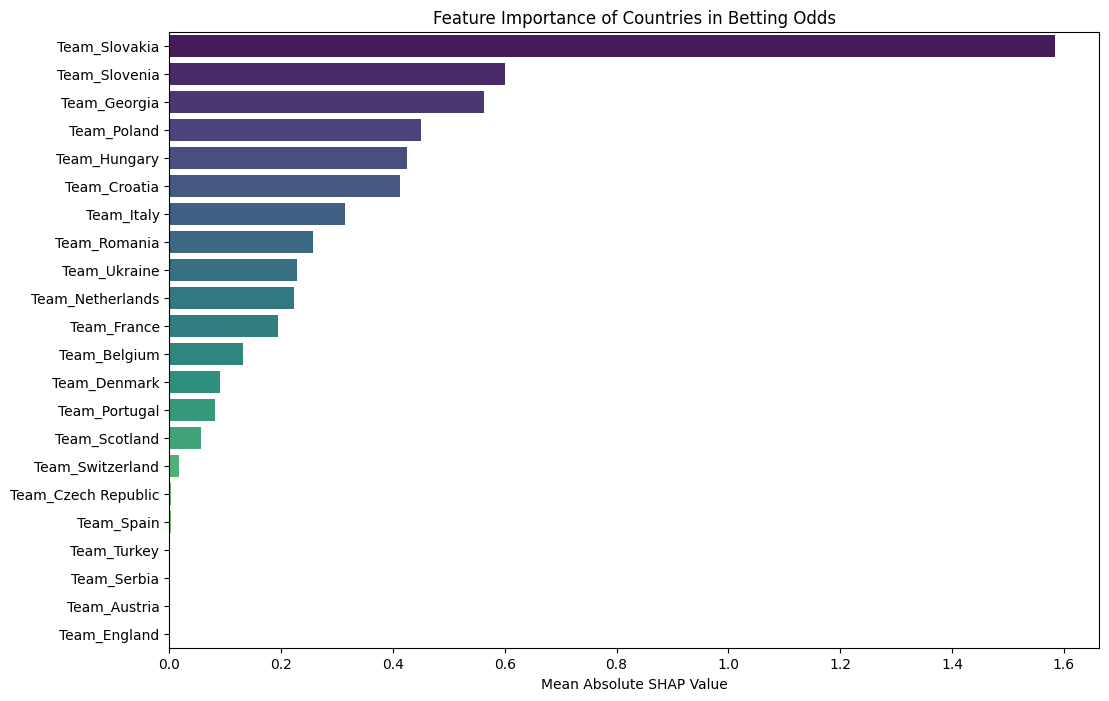

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract sorted lists
countries, importances = zip(*sorted_country_shap_importance)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=countries, palette='viridis')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance of Countries in Betting Odds')
plt.show()

In [289]:
# Example setup
X = data.drop(columns=['Odds_to_One'])
y = data['Odds_to_One']
groups = data['Team']

This analysis was repeated except this time it was ensured that all countries had values represented in both the training and testing datasets. This would mean there were more representative samples and therefore results.

In [290]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)  # Choose the number of splits

for train_index, val_index in group_kfold.split(X, y, groups):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Check the distribution of countries in train and valget
    train_countries = X_train['Team'].unique()
    val_countries = X_val['Team'].unique()

    print("Training countries:", train_countries)
    print("Validation countries:", val_countries)

Training countries: ['Albania' 'Austria' 'Belgium' 'Croatia' 'Denmark' 'England' 'France'
 'Georgia' 'Italy' 'Netherlands' 'Poland' 'Portugal' 'Scotland' 'Serbia'
 'Slovakia' 'Slovenia' 'Switzerland' 'Turkey']
Validation countries: ['Czech Republic' 'Hungary' 'Romania' 'Spain' 'Ukraine']
Training countries: ['Albania' 'Austria' 'Belgium' 'Croatia' 'Czech Republic' 'England'
 'France' 'Georgia' 'Hungary' 'Poland' 'Portugal' 'Romania' 'Serbia'
 'Slovakia' 'Slovenia' 'Spain' 'Turkey' 'Ukraine']
Validation countries: ['Denmark' 'Italy' 'Netherlands' 'Scotland' 'Switzerland']
Training countries: ['Belgium' 'Croatia' 'Czech Republic' 'Denmark' 'France' 'Georgia'
 'Hungary' 'Italy' 'Netherlands' 'Poland' 'Portugal' 'Romania' 'Scotland'
 'Slovakia' 'Slovenia' 'Spain' 'Switzerland' 'Ukraine']
Validation countries: ['Albania' 'Austria' 'England' 'Serbia' 'Turkey']
Training countries: ['Albania' 'Austria' 'Croatia' 'Czech Republic' 'Denmark' 'England'
 'Georgia' 'Hungary' 'Italy' 'Netherlands' 'P

In [291]:
# Assert that all countries are in both train and val
assert set(data['Team'].unique()) == set(train_countries).union(set(val_countries)), "Some countries are missing in either train or validation sets."

The lack of output from the above code shows that coutnries are represented in both training and testing sets.

Data was made numeric and missing data was imputed to ensure models ran.

In [292]:
from sklearn.impute import SimpleImputer
# Handle non-numeric columns
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()
X_encoded = pd.get_dummies(X, columns=non_numeric_columns, drop_first=True)

# Handle numeric columns
numeric_columns = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
X_numeric = X_encoded[numeric_columns]

# Fill missing values
imputer = SimpleImputer(strategy='median')
X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=numeric_columns)

# Combine numeric and encoded features
X_final = pd.concat([X_numeric_imputed, X_encoded.drop(columns=numeric_columns)], axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_final), columns=X_final.columns)

A group k-fold CV was run which keeps similar data together i.e. same country and leads to more reliable results.

In [293]:
# Define your groups
groups = data['Team']

# Initialize GroupKFold
group_kfold = GroupKFold(n_splits=5)

# Store SHAP values and feature values
all_shap_values = []
all_feature_values = []

# Cross-validation loop
for train_index, val_index in group_kfold.split(X_scaled, y, groups):
    X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and fit the Zero-Inflated Poisson model
    zip_model = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit')
    zip_result = zip_model.fit(maxiter=100)

    # Define a custom prediction function for SHAP
    def predict_function(X):
        return zip_result.predict(exog=X, exog_infl=X)

    # Create a SHAP explainer using the custom prediction function
    explainer = shap.Explainer(predict_function, X_train)

    # Calculate SHAP values for the validation fold
    shap_values = explainer(X_val)

    # Collect SHAP values and feature values for this fold
    all_shap_values.append(shap_values.values)
    all_feature_values.append(X_val)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 2.882771
         Iterations: 68
         Function evaluations: 83
         Gradient evaluations: 83


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 2.979329
         Iterations: 64
         Function evaluations: 80
         Gradient evaluations: 80


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 2.921529
         Iterations: 60
         Function evaluations: 77
         Gradient evaluations: 77


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 2.936373
         Iterations: 65
         Function evaluations: 78
         Gradient evaluations: 78


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 2.886637
         Iterations: 59
         Function evaluations: 76
         Gradient evaluations: 76


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


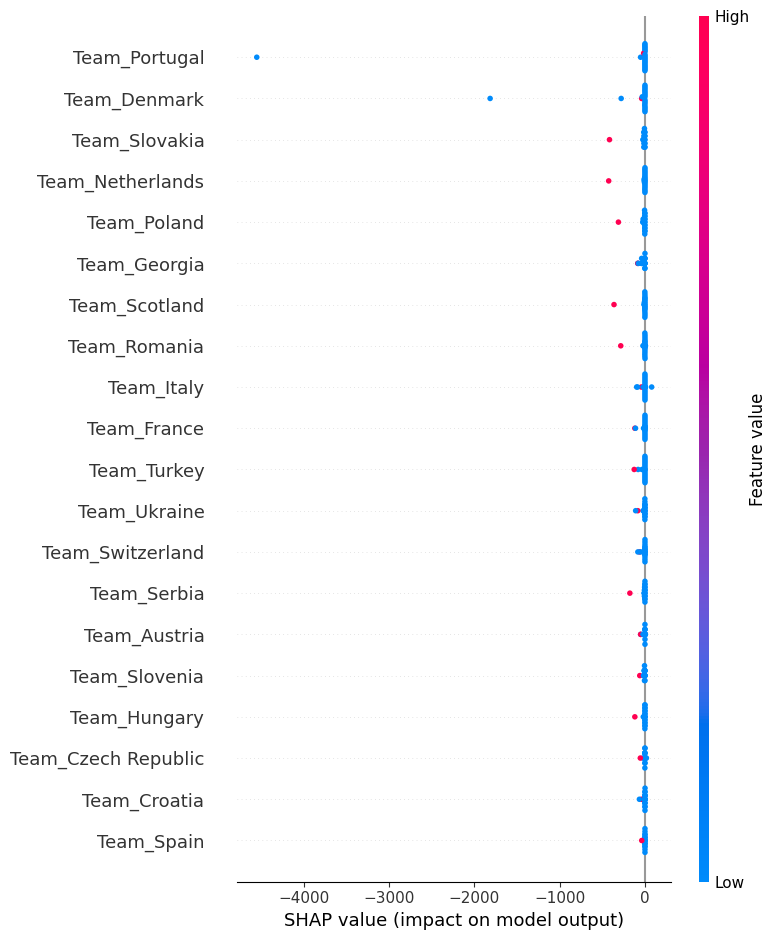

In [294]:
import shap
import pandas as pd
import numpy as np

# Combine SHAP values and feature values from all folds
if all_shap_values:
    # Step 1: Combine SHAP values and feature values
    combined_shap_values = np.vstack(all_shap_values)
    combined_feature_values = np.vstack(all_feature_values)

    # Extract feature names
    feature_names = X_scaled.columns.tolist()

    # Step 2: Identify country columns
    country_columns = [col for col in feature_names if col.startswith('Team_')]

    # Step 3: Filter SHAP values and feature values to include only country-related columns
    shap_country_values = combined_shap_values[:, [feature_names.index(col) for col in country_columns]]
    feature_country_values = combined_feature_values[:, [feature_names.index(col) for col in country_columns]]

    # Step 4: Create a SHAP Explanation object for the country SHAP values
    shap_values_country_combined = shap.Explanation(values=shap_country_values,
                                                    data=feature_country_values,
                                                    feature_names=country_columns)

    # Step 5: Plot the SHAP values for countries
    shap.summary_plot(shap_values_country_combined, feature_country_values, feature_names=country_columns)
else:
    print("No SHAP values collected.")


The grouped k-fold is beneficial in this instance as it ensures that each country is tested. This allows there to be a pink dot on each row. It allows us to analyse which countries odds are influenced the most by the country itself. It is clear to see in this example that Slovakia, Netherlands, Poland, Scotland, Romania, Serbia's odds are most greatly impacted by their nationality. This is an interesting combination of teams with Netherlands classed as joint 7th favourites and the remaining teams towards the lower end of the pre-tournament betting odds. It would appear from this analysis that the country itself does not play a key role in high tournament betting odds and the key features are more centred around Market Value, FIFA Ranking, Caps and Qualifying Performance as discovered previously.